<a href="https://colab.research.google.com/github/cyruskimani/25052021/blob/main/25052021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Analysis Questions
1. Is efficiency higher in the Equal Rationing treatment than in the Proportional Rationing treatment.

2. How does efficiency vary with Group. Is there an interaction with the
treatment?

3. How does the first-stage allowance auction price differ by group/treatment?
Is there an interaction effect?

4. How does overbuying differ by group/treatment? Is there an interaction effect?

5. Is there a difference in first-stage auction participation by treatment?

6. Do any differences between group/treatment persist throughout the
length of the experiment?

In [1]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Importing Libraries.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

## Round Data.

### Round data column descriptions.

In [3]:
round_data_descriptions = pd.read_csv('/content/drive/MyDrive/25052021/round_data_column_desc.csv')
round_data_descriptions

,treatment,"""Proportional"" or ""Equal"" for reserve auction mechanism"
0,group,"""High"" or ""Low"" for whether it was group with..."
1,experiment_id,unique id for each group
2,round,which of 32 auctions
3,auction_price,the price in the first-stage uniform price au...
4,total_demand,the total quantity demanded in the system
5,total_auction_income,auction_price * number of units sold in the a...
6,tier_1_income,number of units sold in the 1st tier * 20
7,tier_2_income,number of units sold in the 2nd tier * 30
8,efficiency,Dependent on the demand profile. efficiency=...
9,demand_profile,there were 8 unique demand curves (value + qu...


### Loading the Data.

In [4]:
# Loading the data.
r_df = pd.read_csv('/content/drive/MyDrive/25052021/round_data.csv')
r_df.head()

,treatment,group,experiment_id,round,auction_price,total_demand,total_auction_income,tier_1_income,tier_2_income,efficiency,demand_profile,overbuying_count,efficiency_relative,high_value_demand,demand_level
0,Proportional,High,0,1,20,168,1200,1000,900,0.840265,5,0,-0.201721,0,2
1,Proportional,High,0,2,30,151,1800,1000,1020,0.870866,3,1,-0.416870,0,1
2,Proportional,High,0,3,50,151,3000,1000,1170,0.938058,3,1,0.320363,0,1
3,Proportional,High,0,4,40,210,2400,1000,1500,0.786597,6,0,0.366418,1,3
4,Proportional,High,0,5,45,210,2700,1000,1500,0.791824,7,0,0.118316,0,3


In [5]:
# Checking for null values.
r_df.isna().sum()

treatment               0
group                   0
experiment_id           0
round                   0
auction_price           0
total_demand            0
total_auction_income    0
tier_1_income           0
tier_2_income           0
efficiency              0
demand_profile          0
overbuying_count        0
efficiency_relative     0
high_value_demand       0
demand_level            0
dtype: int64

* No null values were found.

In [6]:

# Checking for duplicates
r_df.duplicated().sum()

0

* No duplicates were found.

## Subject Data.

In [7]:
subject_data_description = pd.read_csv('/content/drive/MyDrive/25052021/subject_data_column_desc.csv')
subject_data_description

,treatment,"""Proportional"" or ""Equal"" for reserve auction mechanism"
0,group,"""High"" or ""Low"" for whether it was group with..."
1,round,which of the 32 auctions
2,subject_id,unique id for each subject
3,experiment_id,unique id for each group
4,demand_profile,there were 8 unique demand curves (value + qu...
5,high_value_demand,whether the demand profile is one in which bi...
6,demand_level,the level of demand in the profile. Index ve...
7,value,this subject's value this round
8,demand,this subject's total demand for this round
9,auction_bid_price,subject's price bid in the first-stage auction


### Loading the data.

In [8]:
s_df = pd.read_csv('/content/drive/MyDrive/25052021/subject_data.csv')
s_df.head()

,treatment,group,round,subject_id,experiment_id,demand_profile,high_value_demand,demand_level,value,demand,auction_bid_price,auction_bid_quantity,auction_price,auction_received,tier_1_demanded,tier_2_demanded,equal_demanded,tier_1_received,tier_2_received,total_earnings,total_received,overbought
0,Proportional,High,1,0,0,5,0,2,85,17,50,10,20,10,3,2,0,1,2,825,13,0
1,Proportional,High,2,0,0,3,0,1,75,18,65,10,30,10,4,3,0,2,3,695,15,0
2,Proportional,High,3,0,0,3,0,1,55,22,50,15,50,15,4,3,0,2,3,220,20,0
3,Proportional,High,4,0,0,6,1,3,55,21,45,10,40,10,6,4,0,5,3,400,18,0
4,Proportional,High,5,0,0,7,0,3,65,28,45,15,45,15,7,5,0,4,4,620,23,0


In [9]:
# Checking for null values
s_df.isna().sum()

treatment               0
group                   0
round                   0
subject_id              0
experiment_id           0
demand_profile          0
high_value_demand       0
demand_level            0
value                   0
demand                  0
auction_bid_price       0
auction_bid_quantity    0
auction_price           0
auction_received        0
tier_1_demanded         0
tier_2_demanded         0
equal_demanded          0
tier_1_received         0
tier_2_received         0
total_earnings          0
total_received          0
overbought              0
dtype: int64

* No null values

In [10]:
# Checking for duplicates
s_df.duplicated().sum()

0

* No duplicates were found.

## Importing Pymc3.

In [11]:
!pip install pymc3

In [12]:
import pymc3 as pm
import arviz as az
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

### Instantiating the model.

In [13]:
# Finding the  maximum of efficiency
column = r_df["efficiency"]
max_value = column.max()
print(max_value)

1.0


In [14]:
# Finding the  minimum of efficiency
column = r_df["efficiency"]
min_value = column.min()
print(min_value)

0.6439159975293391


In [15]:
# Standard deviation of efficiency
r_df['efficiency'].std()

0.08772730249199161

In [16]:
with pm.Model() as model_g:
    μ = pm.Uniform('μ', lower=0.6439159975293391, upper=1.0)  # Range of Efficiency
    σ = pm.HalfNormal('σ', sd=0.08772730249199161)            # Standard deviation of efficiency
    y = pm.Normal('y', mu=μ, sd=σ, observed=r_df['efficiency'].values)
    trace_g = pm.sample(1000, tune=1000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  """
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, μ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.


### Fitting the model.

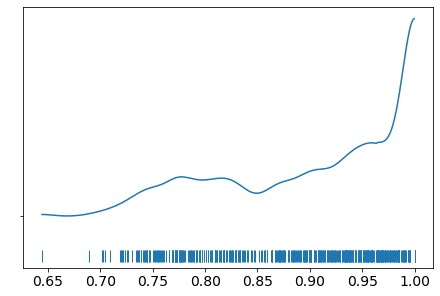

In [17]:
az.plot_kde(r_df['efficiency'].values, rug=True)
plt.yticks([0], alpha=0);

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


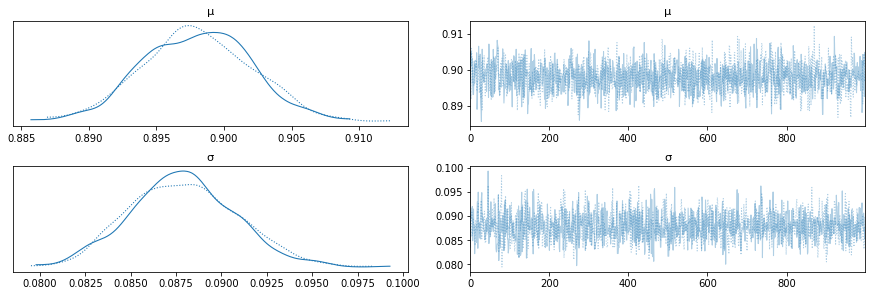

In [18]:
# Plotting the gausian model trace.
az.plot_trace(trace_g);

/usr/local/lib/python3.7/dist-packages/arviz/plots/jointplot.py:144: UserWarning: plot_joint will be deprecated. Please use plot_pair instead.
  warnings.warn("plot_joint will be deprecated. Please use plot_pair instead.")
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


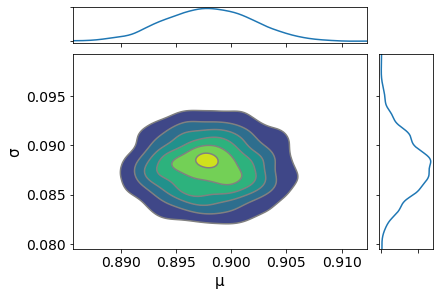

In [19]:
# Plotting joint distribution of parameters
az.plot_joint(trace_g, kind='kde', fill_last=False);

In [20]:
# Detailed summary of the posterior distribution for each parameter.
az.summary(trace_g)

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ,0.898,0.004,0.891,0.906,0.0,0.0,1774.0,1403.0,1.00
σ,0.088,0.003,0.083,0.093,0.0,0.0,1832.0,1216.0,1.01


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


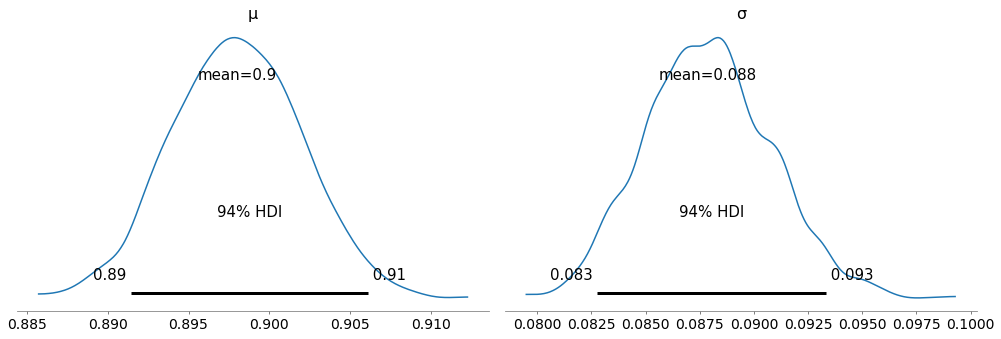

In [21]:
# Plotting the mean and Highest Posterior Density (HPD) of a distribution.
az.plot_posterior(trace_g);

## Analysis Questions.

### Q1. Is efficiency higher in the Equal Rationing treatment than in the Proportional Rationing treatment?**bold text**

In [22]:
# Identifying the unique variables in the treatment column.
r_df['treatment'].unique()

array(['Proportional', 'Equal'], dtype=object)

In [23]:
# We create three variables:
# The efficiency variable, representing the efficiency.
# The idx variable, a categorical dummy variable to encode the treatment categories with numbers.
# And finally the groups variable, with the number of treatment categories

efficiency = r_df['efficiency'].values
idx = pd.Categorical(r_df['treatment'],
                     categories=['Proportional','Equal']).codes
groups = len(np.unique(idx))

In [24]:
# The model for the group comparison.
# pass a shape argument and for the likelihood, we properly index the means
# and sd variables using the idx variable

with pm.Model() as comparing_groups:
    μ = pm.Normal('μ', mu=0, sd=0.08772730249199161, shape=groups)
    σ = pm.HalfNormal('σ', sd=0.08772730249199161, shape=groups)

    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=efficiency)

    trace_groups = pm.sample(5000, tune=5000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  # This is added back by InteractiveShellApp.init_path()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, μ]


Sampling 2 chains for 5_000 tune and 5_000 draw iterations (10_000 + 10_000 draws total) took 21 seconds.


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


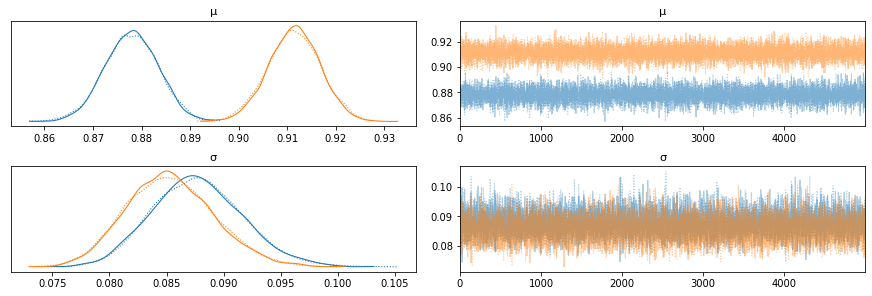

In [25]:
# Plotting the gausian model trace.
az.plot_trace(trace_groups);

* The proportional treatment is represented by the blue line while equal treatment is represented by the orange line.

In [26]:
# Creating a summary table

flat_treatment = az.from_pymc3(trace=trace_groups)
treatment_gaussian = az.summary(flat_treatment)
treatment_gaussian

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ[0],0.878,0.006,0.867,0.888,0.0,0.0,15024.0,7029.0,1.0
μ[1],0.911,0.005,0.902,0.922,0.0,0.0,14593.0,7707.0,1.0
σ[0],0.088,0.004,0.080,0.095,0.0,0.0,15292.0,6152.0,1.0
σ[1],0.085,0.004,0.078,0.093,0.0,0.0,13825.0,7390.0,1.0


* From the results shown in the graphs, the equal treatment is seen to have a better mean efficiency(μ=0.911) and a lower mean standard deviation(σ=0.085), while the proportional treatment had a lower mean efficiency(μ=0.878) and a higher mean standard deviation(σ=0.088).

### Q2. How does efficiency vary with Group. Is there an interaction with the treatment?

In [27]:
# Identifying the unique variables in the group column.
r_df['group'].unique()

array(['High', 'Low'], dtype=object)

In [28]:
# We create three variables:
# The efficiency variable, representing the efficiency.
# The idx variable, a categorical dummy variable to encode the group categories with numbers.
# And finally the groups variable, with the number of group categories

efficiency = r_df['efficiency'].values
idx = pd.Categorical(r_df['group'],
                     categories=['High','Low']).codes
groups = len(np.unique(idx))

In [29]:
# The model for the group comparison.
# pass a shape argument and for the likelihood, we properly index the means
# and sd variables using the idx variable

with pm.Model() as comparing_groups:
    μ = pm.Normal('μ', mu=0, sd=0.08772730249199161, shape=groups)
    σ = pm.HalfNormal('σ', sd=0.08772730249199161, shape=groups)

    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=efficiency)

    trace_groups = pm.sample(5000, tune=5000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  # This is added back by InteractiveShellApp.init_path()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, μ]


Sampling 2 chains for 5_000 tune and 5_000 draw iterations (10_000 + 10_000 draws total) took 22 seconds.


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


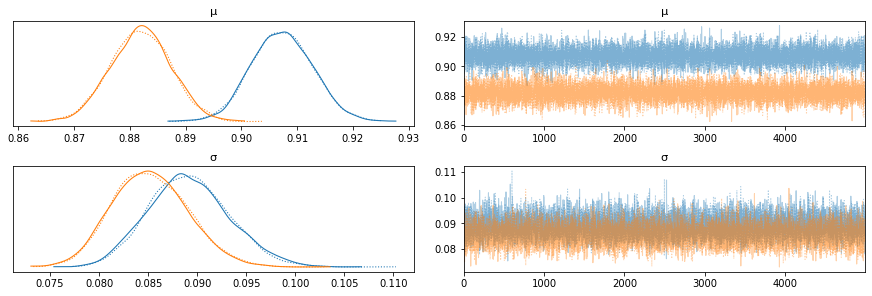

In [30]:
# Plotting the gausian model trace.
az.plot_trace(trace_groups);

In [31]:
# Creating a summary table

flat_treatment = az.from_pymc3(trace=trace_groups)
treatment_gaussian = az.summary(flat_treatment)
treatment_gaussian

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ[0],0.907,0.005,0.897,0.918,0.0,0.0,15780.0,7969.0,1.0
μ[1],0.882,0.005,0.872,0.892,0.0,0.0,16721.0,7934.0,1.0
σ[0],0.089,0.004,0.081,0.097,0.0,0.0,17719.0,7473.0,1.0
σ[1],0.085,0.004,0.078,0.092,0.0,0.0,15787.0,7502.0,1.0


*  From the results shown in the graphs, the group with highquiz scores is seen to have a better mean efficiency(μ=0.907) and a higher mean standard deviation(σ=0.089), while the group with low quiz scores had a lower mean efficiency(μ=0.089) and a lower mean standard deviation (σ=0.085).

### Q3. How does the first-stage allowance auction price differ by group/treatment? Is there an interaction effect?

#### First-stage allowance auction price vs group.

In [32]:
# Identifying the unique variables in the group column.
r_df['group'].unique()

array(['High', 'Low'], dtype=object)

In [33]:
# Standard deviation of efficiency
r_df['auction_price'].std()

14.86095646315389

In [34]:
# We create three variables:
# The first_stage_allowance variable, representing the first_stage_allowance.
# The idx variable, a categorical dummy variable to encode the group categories with numbers.
# And finally the groups variable, with the number of group categories

#df = r_df[r_df.auction_price != 0]
first_stage_allowance = r_df['auction_price'].values
idx = pd.Categorical(r_df['group'],
                     categories=['High','Low']).codes
groups = len(np.unique(idx))

In [35]:
# The model for the group comparison.
# pass a shape argument and for the likelihood, we properly index the means
# and sd variables using the idx variable

with pm.Model() as comparing_groups:
    μ = pm.Normal('μ', mu=0, sd=14.86095646315389, shape=groups)
    σ = pm.HalfNormal('σ', sd=14.86095646315389, shape=groups)

    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=first_stage_allowance)

    trace_groups = pm.sample(5000, tune=5000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  # This is added back by InteractiveShellApp.init_path()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, μ]


Sampling 2 chains for 5_000 tune and 5_000 draw iterations (10_000 + 10_000 draws total) took 21 seconds.


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


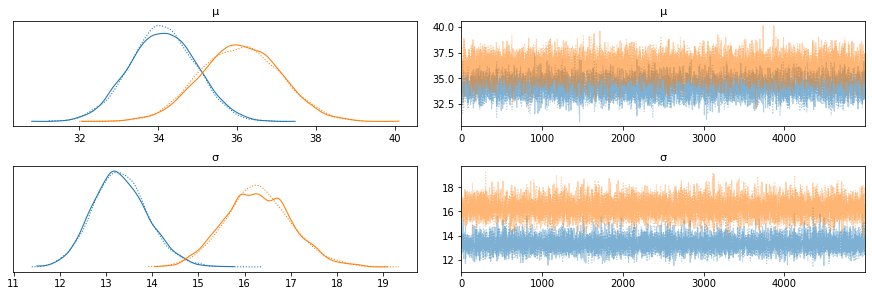

In [36]:
# Plotting the gausian model trace.
az.plot_trace(trace_groups);

In [37]:
# Creating a summary table

flat_treatment = az.from_pymc3(trace=trace_groups)
treatment_gaussian = az.summary(flat_treatment)
treatment_gaussian

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ[0],34.112,0.840,32.548,35.695,0.007,0.005,15263.0,8030.0,1.0
μ[1],36.078,1.012,34.256,38.003,0.008,0.006,16102.0,7879.0,1.0
σ[0],13.312,0.598,12.255,14.508,0.005,0.003,16047.0,6540.0,1.0
σ[1],16.298,0.729,14.920,17.661,0.006,0.004,16186.0,7182.0,1.0


*  From the results shown in the graphs, the group with low quiz scores is seen to have a better mean auction price (μ=36.078) and a high mean standard deviation(σ=16.298), while the group with high quiz scores had a lower mean auction price (μ=34.112) and a lower mean standard deviation (σ=13.312).

#### First-stage allowance auction price vs treatment.

In [38]:
# Identifying the unique variables in the treatment column.
r_df['treatment'].unique()

array(['Proportional', 'Equal'], dtype=object)

In [39]:
# We create three variables:
# The first_stage_allowance variable, representing the first_stage_allowance.
# The idx variable, a categorical dummy variable to encode the treatment categories with numbers.
# And finally the groups variable, with the number of treatment categories

#df = r_df[r_df.auction_price != 0]
first_stage_allowance = r_df['auction_price'].values
idx = pd.Categorical(r_df['treatment'],
                     categories=['Proportional','Equal']).codes
groups = len(np.unique(idx))

In [40]:
# The model for the group comparison.
# pass a shape argument and for the likelihood, we properly index the means
# and sd variables using the idx variable

with pm.Model() as comparing_groups:
    μ = pm.Normal('μ', mu=0, sd=14.86095646315389, shape=groups)
    σ = pm.HalfNormal('σ', sd=14.86095646315389, shape=groups)

    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=first_stage_allowance)

    trace_groups = pm.sample(5000, tune=5000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  # This is added back by InteractiveShellApp.init_path()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, μ]


Sampling 2 chains for 5_000 tune and 5_000 draw iterations (10_000 + 10_000 draws total) took 20 seconds.


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


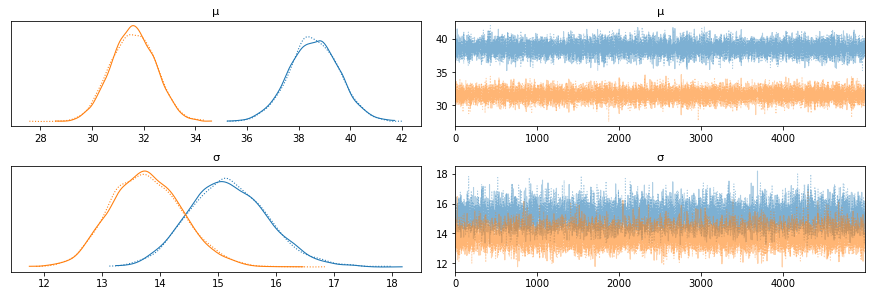

In [41]:
# Plotting the gausian model trace.
az.plot_trace(trace_groups);

In [42]:
# Creating a summary table

flat_treatment = az.from_pymc3(trace=trace_groups)
treatment_gaussian = az.summary(flat_treatment)
treatment_gaussian

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ[0],38.597,0.960,36.812,40.447,0.008,0.006,14659.0,7710.0,1.0
μ[1],31.588,0.859,30.050,33.218,0.007,0.005,15997.0,7874.0,1.0
σ[0],15.180,0.687,13.837,16.402,0.006,0.004,14078.0,6860.0,1.0
σ[1],13.772,0.618,12.652,14.927,0.005,0.004,15562.0,7642.0,1.0


* From the results shown in the graphs, the proportional treatment is seen to have a better mean auction price (μ=38.597) and a high mean standard deviation(σ=15.180), while the equal treatment had a lower mean auction price (μ=31.588) and a lower mean standard deviation (σ=13.772).

### Q4. How does overbuying differ by group/treatment? Is there an interaction effect?

#### overbuying_count vs group.

In [43]:
# Identifying the unique variables in the group column.
r_df['group'].unique()

array(['High', 'Low'], dtype=object)

In [44]:
# Standard deviation of efficiency
r_df['overbuying_count'].std()

0.9096944714084805

In [45]:
# We create three variables:
# The overbuying_count variable, representing the overbuying_count.
# The idx variable, a categorical dummy variable to encode the group categories with numbers.
# And finally the groups variable, with the number of group categories

overbuying_count = r_df['overbuying_count'].values
idx = pd.Categorical(r_df['group'],
                     categories=['High','Low']).codes
groups = len(np.unique(idx))

In [46]:
# The model for the group comparison.
# pass a shape argument and for the likelihood, we properly index the means
# and sd variables using the idx variable

with pm.Model() as comparing_groups:
    μ = pm.Normal('μ', mu=0, sd=0.9096944714084805, shape=groups)
    σ = pm.HalfNormal('σ', sd=0.9096944714084805, shape=groups)

    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=overbuying_count)

    trace_groups = pm.sample(5000, tune=5000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  # This is added back by InteractiveShellApp.init_path()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, μ]


Sampling 2 chains for 5_000 tune and 5_000 draw iterations (10_000 + 10_000 draws total) took 20 seconds.


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


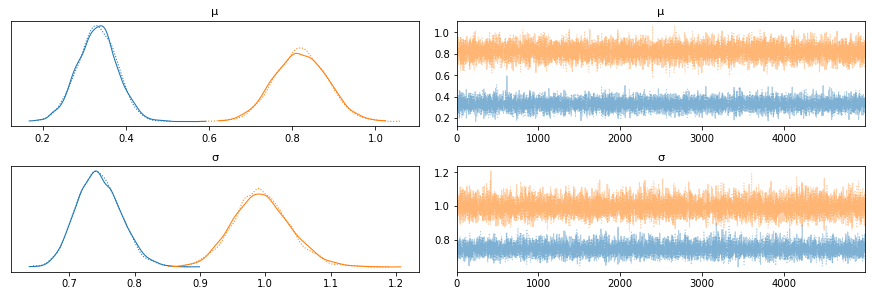

In [47]:
# Plotting the gausian model trace.
az.plot_trace(trace_groups);

In [48]:
# Creating a summary table

flat_treatment = az.from_pymc3(trace=trace_groups)
treatment_gaussian = az.summary(flat_treatment)
treatment_gaussian

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ[0],0.331,0.047,0.243,0.422,0.000,0.0,13724.0,6855.0,1.0
μ[1],0.820,0.063,0.698,0.933,0.001,0.0,13801.0,7178.0,1.0
σ[0],0.745,0.033,0.686,0.808,0.000,0.0,14452.0,7042.0,1.0
σ[1],0.995,0.044,0.912,1.078,0.000,0.0,12806.0,7491.0,1.0


* From the results shown in the graphs, the group with low quiz scores is seen to have a higher overbuying count (μ=0.820) and a high mean standard deviation(σ=0.995), while the group with high quiz scores had a lower overbuying count (μ=0.331) and a lower mean standard deviation (σ=0.745).

#### overbuying_count vs treatment.

In [49]:
# Identifying the unique variables in the group column.
r_df['treatment'].unique()

array(['Proportional', 'Equal'], dtype=object)

In [50]:
# We create three variables:
# The overbuying_count variable, representing the overbuying_count.
# The idx variable, a categorical dummy variable to encode the treatment categories with numbers.
# And finally the groups variable, with the number of treatment categories

overbuying_count = r_df['overbuying_count'].values
idx = pd.Categorical(r_df['treatment'],
                     categories=['Proportional','Equal']).codes
groups = len(np.unique(idx))

In [51]:
# The model for the group comparison.
# pass a shape argument and for the likelihood, we properly index the means
# and sd variables using the idx variable

with pm.Model() as comparing_groups:
    μ = pm.Normal('μ', mu=0, sd=0.9096944714084805, shape=groups)
    σ = pm.HalfNormal('σ', sd=0.9096944714084805, shape=groups)

    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=overbuying_count)

    trace_groups = pm.sample(5000, tune=5000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  # This is added back by InteractiveShellApp.init_path()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, μ]


Sampling 2 chains for 5_000 tune and 5_000 draw iterations (10_000 + 10_000 draws total) took 20 seconds.


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


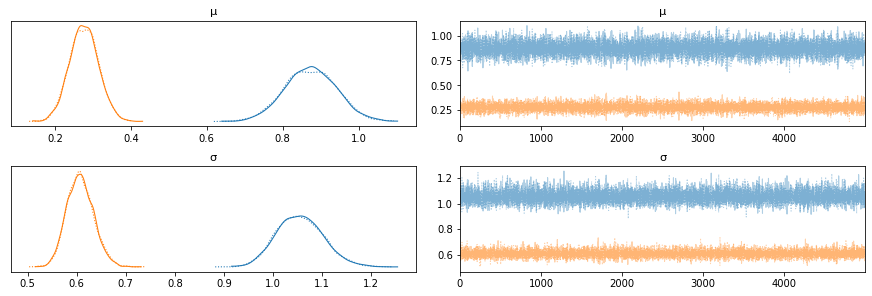

In [52]:
# Plotting the gausian model trace.
az.plot_trace(trace_groups);

In [53]:
# Creating a summary table

flat_treatment = az.from_pymc3(trace=trace_groups)
treatment_gaussian = az.summary(flat_treatment)
treatment_gaussian

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ[0],0.874,0.068,0.742,0.996,0.001,0.0,15135.0,7054.0,1.0
μ[1],0.277,0.038,0.205,0.348,0.000,0.0,15865.0,7375.0,1.0
σ[0],1.056,0.047,0.971,1.146,0.000,0.0,16586.0,7707.0,1.0
σ[1],0.607,0.027,0.560,0.661,0.000,0.0,15234.0,7548.0,1.0


* From the results shown in the graphs, the proportional treatment is seen to have a higher overbuying count (μ=0.874) and a high mean standard deviation(σ=1.056), while the equal treatment had a lower overbuying count (μ=0.277) and a lower mean standard deviation (σ=0.607).

### Q5. Is there a difference in first-stage auction participation by treatment?

In [54]:
# Identifying the unique variables in the treatment column.
s_df['treatment'].unique()

array(['Proportional', 'Equal'], dtype=object)

In [55]:
# Standard deviation of first-stage auction participation
s_df['auction_received'].std()

7.8086297342649535

In [56]:
# We create three variables:
# The auction_received variable, representing the auction_received.
# The idx variable, a categorical dummy variable to encode the treatment categories with numbers.
# And finally the groups variable, with the number of treatment categories

auction_received = s_df['auction_received'].values
idx = pd.Categorical(s_df['treatment'],
                     categories=['Proportional','Equal']).codes
groups = len(np.unique(idx))

In [57]:
# The model for the group comparison.
# pass a shape argument and for the likelihood, we properly index the means
# and sd variables using the idx variable

with pm.Model() as comparing_groups:
    μ = pm.Normal('μ', mu=0, sd=7.8086297342649535, shape=groups)
    σ = pm.HalfNormal('σ', sd=7.8086297342649535, shape=groups)

    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=auction_received)

    trace_groups = pm.sample(5000, tune=5000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  # This is added back by InteractiveShellApp.init_path()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, μ]


Sampling 2 chains for 5_000 tune and 5_000 draw iterations (10_000 + 10_000 draws total) took 42 seconds.


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


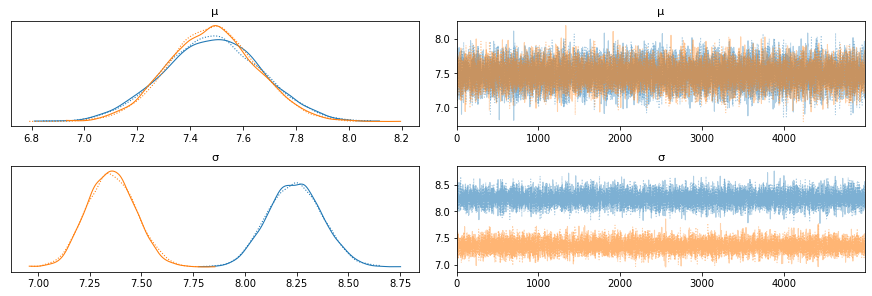

In [58]:
# Plotting the gausian model trace.
az.plot_trace(trace_groups);

In [59]:
# Creating a summary table

flat_treatment = az.from_pymc3(trace=trace_groups)
treatment_gaussian = az.summary(flat_treatment)
treatment_gaussian

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ[0],7.485,0.184,7.139,7.829,0.001,0.001,16559.0,7339.0,1.0
μ[1],7.483,0.166,7.185,7.807,0.001,0.001,16044.0,7496.0,1.0
σ[0],8.242,0.131,7.993,8.481,0.001,0.001,16940.0,7875.0,1.0
σ[1],7.355,0.117,7.149,7.578,0.001,0.001,18071.0,7382.0,1.0


* From the results shown in the graphs, the proportional treatment is seen to have a higher first-stage auction participation (μ=7.485) and a high mean standard deviation(σ=8.242), while the equal treatment had a lower first-stage auction participation (μ=7.483) and a lower mean standard deviation (σ=7.355).

### Q6. Do any differences between group/treatment persist throughout the length of the experiment?


* The equal treatment better efficiency lower standard deviation, proportional treatment had lower efficiency and high standard deviation.


* The group with high quiz scores had better efficiency and a high standard deviation, the group with lower quiz scores had lower efficiency and low standard deviation.


*  From the results shown in the graphs, the group with low quiz scores is seen to have a better mean auction price (μ=36.078) and a high mean standard deviation(σ=16.298), while the group with high quiz scores had a lower mean auction price (μ=34.112) and a lower mean standard deviation (σ=13.312).

* From the results shown in the graphs, the proportional treatment is seen to have a better mean auction price (μ=38.597) and a high mean standard deviation(σ=15.180), while the equal treatment had a lower mean auction price (μ=31.588) and a lower mean standard deviation (σ=13.772).

* From the results shown in the graphs, the group with low quiz scores is seen to have a higher overbuying count (μ=0.820) and a high mean standard deviation(σ=0.995), while the group with high quiz scores had a lower overbuying count (μ=0.331) and a lower mean standard deviation (σ=0.745).

* From the results shown in the graphs, the proportional treatment is seen to have a higher overbuying count (μ=0.874) and a high mean standard deviation(σ=1.056), while the equal treatment had a lower overbuying count (μ=0.277) and a lower mean standard deviation (σ=0.607).

* From the results shown in the graphs, the proportional treatment is seen to have a higher first-stage auction participation (μ=7.485) and a high mean standard deviation(σ=8.242), while the equal treatment had a lower first-stage auction participation (μ=7.483) and a lower mean standard deviation (σ=7.355).
